# TP1 de IFT-3700
Mehdi Aqdim

Maxime Daigle

Adam Félix

Jonathan Graveline

## Preprocessing

Charger les données

et reduire les pixels a noir ou blanc (0 ou 1)

In [1]:
import numpy as np
import time
from sklearn.preprocessing import Binarizer

"""
    Mettre `skiprows=1` pour avoir toutes les données.
    (Mais c'est très long surtout pour faire des tests.)
"""
mnist_train = np.loadtxt('mnist_train.csv', dtype='int', delimiter=',', skiprows=59001)
mnist_test  = np.loadtxt('mnist_test.csv', dtype='int', delimiter=',', skiprows=9501)

#print(mnist_train[0])

train_label = mnist_train[:,0]
train_data  = mnist_train[:,1:]

test_label  = mnist_test[:,0]
test_data   = mnist_test[:,1:]

#print(train_data.shape[1])

"""
    Décommentez les 5 lignes suivantes pour
        avoir des valeurs binaires
        (10 c'est le treshold... 128 serait peut-être mieux)
"""

#pp = Binarizer(10)

#pp.fit(train_data)
#train_data_d1 = pp.transform(train_data)

#pp.fit(test_data)
#test_data_d1  = pp.transform(test_data)

#print(train_data.shape[1])
#print(train_data[0])

"\n    Décommentez les 5 lignes suivantes pour\n        avoir des valeurs binaires\n        (10 c'est le treshold... 128 serait peut-être mieux)\n"

## Mesures

In [2]:
# distance euclidien
from sklearn.metrics import euclidean_distances

# Similarité cosine
# http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
from sklearn.metrics.pairwise import cosine_similarity

# Chi2 kernel
# http://scikit-learn.org/stable/modules/metrics.html#chi-squared-kernel
from sklearn.metrics.pairwise import chi2_kernel

# Sigmoid kernel
# http://scikit-learn.org/stable/modules/metrics.html#sigmoid-kernel
from sklearn.metrics.pairwise import sigmoid_kernel

# RBF kernel
# http://scikit-learn.org/stable/modules/metrics.html#rbf-kernel
from sklearn.metrics.pairwise import rbf_kernel

# Laplacian kernel
# http://scikit-learn.org/stable/modules/metrics.html#laplacian-kernel
from sklearn.metrics.pairwise import laplacian_kernel

# Polynomial kernel
# http://scikit-learn.org/stable/modules/metrics.html#polynomial-kernel
from sklearn.metrics.pairwise import polynomial_kernel

"""
Autre mesure possiblement interessante
from scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]
from scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, 
                              ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, 
                              ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]
"""



## Distance, essai 1: density

C'est une facon de considerer les points voisins dans le calcul. Ce qui je crois devrais aider...

Calcul de la densite a chaque point:

In [ ]:
def in_bounds(pi, x, y):
    ret = pi + x + (y * 28)
    if ret > 783:
        return 783
    elif ret < 0:
        return 0
    else:
        return ret

def get_density(data, radius):
    rdata = []
    rrange = range(-radius,radius+1)
    for ei in range(data.shape[0]):
        ex = data[ei]
        nex = []
        for pi in range(ex.shape[0]):
            nex.append(sum([ex[in_bounds(pi,x,y)] for x in rrange for y in rrange]))
        rdata.append(nex)
    return np.array(rdata)

train_data_d1 = get_density(train_data, 1)
test_data_d1  = get_density(test_data, 1)

#print(pp_data.shape[1])
#print(pp_data[0])

In [ ]:

"""
    Note 1: This is useless, data set is already transformed,
        so we may use euclidean distance directly on density map.
    
    Note 2: Built-in euclidean is way faster! Better hack data set
        and use built-in euclidean.
"""
def distance_1(lhs, rhs):
    #assert(lhs.shape == rhs.shape)
    ret = 0
    for pi in range(lhs.shape[0]):
        ret += abs(lhs[pi] - rhs[pi])
    return ret

print('Distance of train_data[0] to itself == %d' % distance_1(train_data[0],train_data[0]))

## KNN

Algorithme de classification

In [ ]:
from sklearn.neighbors import NearestNeighbors

def knn(n, r, d):
    return NearestNeighbors(n, r, metric=d, n_jobs=6)

## Evaluation of performance:

In [ ]:
def get_best(idxs, train_label):
    counts = np.bincount(train_label[idxs])
    return np.argmax(counts)

def perf_knn(train_set, train_label, test_set, test_label):
    n_tests = test_label.shape[0]
    
    algo = knn(11, 1.0, 'euclidean')
    algo.fit(train_set)
    
    idxs = algo.kneighbors(test_set, return_distance=False)
    
    ret = sum([(get_best(idxs[idx], train_label) == test_label[idx]) for idx in range(n_tests)])
    
    return ((ret * 100.0) / test_set.shape[0])

In [ ]:
""" Avec les données modifiées. """
result = perf_knn(train_data_d1, train_label, test_data_d1, test_label)

print('perf_knn (distance_1) == %.4f %%' % result)

""" Avec les données originales. """
result = perf_knn(train_data, train_label, test_data, test_label)

print('perf_knn (euclidean)  == %.4f %%' % result)

## Isomap

Algorithme de reduction de dimensionnalite

##### Modified isomap from scikit learn to be able to change the metric used

In [3]:
"""Isomap for manifold learning"""

# Author: Jake Vanderplas  -- <vanderplas@astro.washington.edu>
# License: BSD 3 clause (C) 2011

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.utils import check_array
from sklearn.utils.graph import graph_shortest_path
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import KernelCenterer

#_____________________________
# ____________ADDED___________
#_____________________________
""" 
It is now possible to specify the metric use in fit_transform()


metric : string or callable, default ‘minkowski’
metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.

If metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. 
The callable should take two arrays as input and return one value indicating the distance between them. 
This works for Scipy’s metrics, but is less efficient than passing the metric name as a string.

Distance matrices are not supported.

Valid values for metric are:
from scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]
from scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, 
                              ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, 
                              ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]
"""


class Isomap(BaseEstimator, TransformerMixin):
    """Isomap Embedding
    Non-linear dimensionality reduction through Isometric Mapping
    Read more in the :ref:`User Guide <isomap>`.
    Parameters
    ----------
    n_neighbors : integer
        number of neighbors to consider for each point.
    n_components : integer
        number of coordinates for the manifold
    eigen_solver : ['auto'|'arpack'|'dense']
        'auto' : Attempt to choose the most efficient solver
        for the given problem.
        'arpack' : Use Arnoldi decomposition to find the eigenvalues
        and eigenvectors.
        'dense' : Use a direct solver (i.e. LAPACK)
        for the eigenvalue decomposition.
    tol : float
        Convergence tolerance passed to arpack or lobpcg.
        not used if eigen_solver == 'dense'.
    max_iter : integer
        Maximum number of iterations for the arpack solver.
        not used if eigen_solver == 'dense'.
    path_method : string ['auto'|'FW'|'D']
        Method to use in finding shortest path.
        'auto' : attempt to choose the best algorithm automatically.
        'FW' : Floyd-Warshall algorithm.
        'D' : Dijkstra's algorithm.
    neighbors_algorithm : string ['auto'|'brute'|'kd_tree'|'ball_tree']
        Algorithm to use for nearest neighbors search,
        passed to neighbors.NearestNeighbors instance.
    n_jobs : int or None, optional (default=None)
        The number of parallel jobs to run.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    Attributes
    ----------
    embedding_ : array-like, shape (n_samples, n_components)
        Stores the embedding vectors.
    kernel_pca_ : object
        `KernelPCA` object used to implement the embedding.
    training_data_ : array-like, shape (n_samples, n_features)
        Stores the training data.
    nbrs_ : sklearn.neighbors.NearestNeighbors instance
        Stores nearest neighbors instance, including BallTree or KDtree
        if applicable.
    dist_matrix_ : array-like, shape (n_samples, n_samples)
        Stores the geodesic distance matrix of training data.
    Examples
    --------
    >>> from sklearn.datasets import load_digits
    >>> from sklearn.manifold import Isomap
    >>> X, _ = load_digits(return_X_y=True)
    >>> X.shape
    (1797, 64)
    >>> embedding = Isomap(n_components=2)
    >>> X_transformed = embedding.fit_transform(X[:100])
    >>> X_transformed.shape
    (100, 2)
    References
    ----------
    .. [1] Tenenbaum, J.B.; De Silva, V.; & Langford, J.C. A global geometric
           framework for nonlinear dimensionality reduction. Science 290 (5500)
    """
    
    def __init__(self, n_neighbors=5, n_components=2, eigen_solver='auto',
                 tol=0, max_iter=None, path_method='auto',
                 neighbors_algorithm='auto', n_jobs=None):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.eigen_solver = eigen_solver
        self.tol = tol
        self.max_iter = max_iter
        self.path_method = path_method
        self.neighbors_algorithm = neighbors_algorithm
        self.n_jobs = n_jobs

    ##_____________________________
    ##added metric = ''minkowski'
    ##_____________________________
    def _fit_transform(self, X, metric = 'minkowski'):
        X = check_array(X, accept_sparse='csr')
        
        ##__________________________________________________
        ##added metric=metric
        ##_________________________________________________
        self.nbrs_ = NearestNeighbors(n_neighbors=self.n_neighbors,
                                      algorithm=self.neighbors_algorithm,
                                      n_jobs=self.n_jobs, metric=metric)
        self.nbrs_.fit(X)
        self.training_data_ = self.nbrs_._fit_X
        self.kernel_pca_ = KernelPCA(n_components=self.n_components,
                                     kernel="precomputed",
                                     eigen_solver=self.eigen_solver,
                                     tol=self.tol, max_iter=self.max_iter,
                                     n_jobs=self.n_jobs)
        ##____________________________________________________
        ##added metric=metric
        ##____________________________________________________
        kng = kneighbors_graph(self.nbrs_, self.n_neighbors,
                               mode='distance', n_jobs=self.n_jobs, metric = metric)

        self.dist_matrix_ = graph_shortest_path(kng,
                                                method=self.path_method,
                                                directed=False)
        G = self.dist_matrix_ ** 2
        G *= -0.5

        self.embedding_ = self.kernel_pca_.fit_transform(G)

    def reconstruction_error(self):
        """Compute the reconstruction error for the embedding.
        Returns
        -------
        reconstruction_error : float
        Notes
        -------
        The cost function of an isomap embedding is
        ``E = frobenius_norm[K(D) - K(D_fit)] / n_samples``
        Where D is the matrix of distances for the input data X,
        D_fit is the matrix of distances for the output embedding X_fit,
        and K is the isomap kernel:
        ``K(D) = -0.5 * (I - 1/n_samples) * D^2 * (I - 1/n_samples)``
        """
        G = -0.5 * self.dist_matrix_ ** 2
        G_center = KernelCenterer().fit_transform(G)
        evals = self.kernel_pca_.lambdas_
        return np.sqrt(np.sum(G_center ** 2) - np.sum(evals ** 2)) / G.shape[0]

    def fit(self, X, y=None):
        """Compute the embedding vectors for data X
        Parameters
        ----------
        X : {array-like, sparse matrix, BallTree, KDTree, NearestNeighbors}
            Sample data, shape = (n_samples, n_features), in the form of a
            numpy array, precomputed tree, or NearestNeighbors
            object.
        y : Ignored
        Returns
        -------
        self : returns an instance of self.
        """
        self._fit_transform(X)
        return self

    ##_____________________________
    ##added metric = ''minkowski'
    ##_____________________________
    def fit_transform(self, X, y=None, metric = 'minkowski'):
        """Fit the model from data in X and transform X.
        Parameters
        ----------
        X : {array-like, sparse matrix, BallTree, KDTree}
            Training vector, where n_samples in the number of samples
            and n_features is the number of features.
        y : Ignored
        Returns
        -------
        X_new : array-like, shape (n_samples, n_components)
        """
        ##_____________________________
        ##added metric
        ##_____________________________
        self._fit_transform(X, metric)
        return self.embedding_

    def transform(self, X):
        """Transform X.
        This is implemented by linking the points X into the graph of geodesic
        distances of the training data. First the `n_neighbors` nearest
        neighbors of X are found in the training data, and from these the
        shortest geodesic distances from each point in X to each point in
        the training data are computed in order to construct the kernel.
        The embedding of X is the projection of this kernel onto the
        embedding vectors of the training set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        Returns
        -------
        X_new : array-like, shape (n_samples, n_components)
        """
        X = check_array(X)
        distances, indices = self.nbrs_.kneighbors(X, return_distance=True)

        # Create the graph of shortest distances from X to self.training_data_
        # via the nearest neighbors of X.
        # This can be done as a single array operation, but it potentially
        # takes a lot of memory.  To avoid that, use a loop:
        G_X = np.zeros((X.shape[0], self.training_data_.shape[0]))
        for i in range(X.shape[0]):
            G_X[i] = np.min(self.dist_matrix_[indices[i]] +
                            distances[i][:, None], 0)

        G_X **= 2
        G_X *= -0.5

        return self.kernel_pca_.transform(G_X)

In [4]:
# Isomap reduisant à 2d
iso_2d = Isomap(n_components=2, n_jobs=-1)

#Isomap with euclidean distance
start = time.time()
iso_pos_euclidean = iso_2d.fit_transform(train_data, metric = 'euclidean')
end = time.time()
print(end-start, 'seconds')

1.426626443862915 seconds


In [5]:
#Isomap with cosine similarity
start = time.time()
iso_pos_cosine = iso_2d.fit_transform(train_data, metric='cosine')
end = time.time()
print(end-start, 'seconds')

4.607657194137573 seconds


## PCoA

Algorithme de reduction de dimensionnalite

In [6]:
seed = np.random.RandomState(seed=3)

from sklearn.manifold import MDS

#PCoA reducing to 2 dimensions
mds = MDS(n_components=2, random_state=seed, dissimilarity="precomputed", n_jobs=-1)

distance euclidien 

In [7]:
start = time.time()
similarities_euclidean = euclidean_distances(train_data)
pos_euclidean = mds.fit(similarities_euclidean).embedding_
end = time.time()
print(end-start, 'seconds')

30.368866443634033 seconds


Similarité cosine

http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity

In [ ]:
start = time.time()
similarities = cosine_similarity(train_data)
pos_cosine = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

Chi2 kernel

http://scikit-learn.org/stable/modules/metrics.html#chi-squared-kernel

In [ ]:
start = time.time()
similarities = chi2_kernel(train_data)
pos_chi2 = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

Sigmoid kernel

http://scikit-learn.org/stable/modules/metrics.html#sigmoid-kernel

In [ ]:
start = time.time()
similarities = sigmoid_kernel(train_data)
pos_sigmoid = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

RBF kernel

http://scikit-learn.org/stable/modules/metrics.html#rbf-kernel

In [ ]:
start = time.time()
similarities = rbf_kernel(train_data)
pos_rbf = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

Laplacian kernel

http://scikit-learn.org/stable/modules/metrics.html#laplacian-kernel

In [ ]:
start = time.time()
similarities = laplacian_kernel(train_data)
pos_laplacian = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

Polynomial kernel

http://scikit-learn.org/stable/modules/metrics.html#polynomial-kernel

In [ ]:
start = time.time()
similarities = polynomial_kernel(train_data)
pos_polynomial = mds.fit(similarities).embedding_
end = time.time()
print(end-start, 'seconds')

### Visualize Dimensionality reduction in 2d

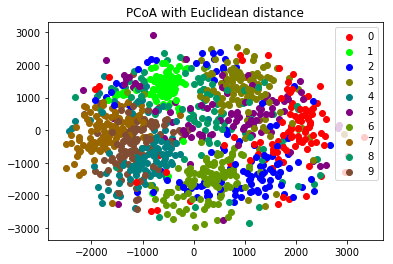

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
def visualize_2d(pos,title):
    fig, ax = plt.subplots()
    colors=((1,0,0),(0,1,0),(0,0,1),(0.5,0.5,0),(0,0.5,0.5),(0.5,0,0.5),(0.4,0.6,0),(0.6,0.4,0),(0,0.6,0.4),(0.5,0.3,0.2),)
    for i in range(pos.shape[0]):
        ax.scatter(pos[i,0],pos[i,1],label = train_label[i],color=colors[train_label[i]])

    #remove duplicate in legend
    handles,labels=ax.get_legend_handles_labels()
    handles_unique, labels_unique = [],[]
    seen = set()
    for i,e in enumerate(labels):
        if e not in seen:
            seen.add(e)
            handles_unique.append(handles[i])
            labels_unique.append(e)
            if len(seen) == 10:
                break

    #sort legend
    labels_unique, handles_unique = (list(l) for l in zip(*sorted(zip(labels_unique, handles_unique))))

    plt.legend(handles_unique,labels_unique,loc="best")
    plt.title(title)
    plt.show()

    

#Example: visualization of euclidean distance
visualize_2d(pos_euclidean, "PCoA with Euclidean distance")


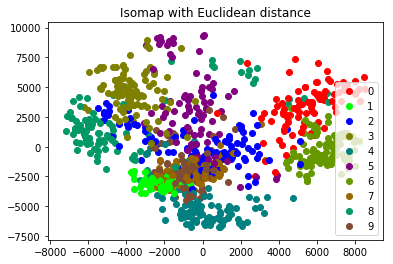

In [9]:
visualize_2d(iso_pos_euclidean, 'Isomap with Euclidean distance')

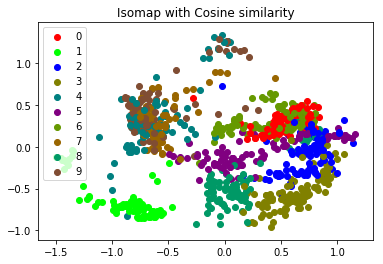

In [10]:
visualize_2d(iso_pos_cosine, 'Isomap with Cosine similarity')